## Imports

In [1]:
from ipynb.fs.full.Residual import *
from ipynb.fs.full.Jacobian import *

import numpy as np
from numpy import linalg as LA
import sympy as sp

import matplotlib.pyplot as plt
import math

24
0.0200000000000000
f(x) = 6*x
f(x) = 45*x**2 + 36*x


## Global Variables

In [30]:
#Time variables
interval = 3
delta = 0.1

#Number represent how far we want to be precised.
Epsilon = 10**-2

## Main Program

In [37]:
def function_f(uk, uk_1, expr, first):
    f_uk = 0
    
    #First call of this function
    if(first):
        f_uk = evaluate(uk, expr)
    else:
        f_uk = (uk - uk_1 / delta) - evaluate(uk, expr)
    
    return f_uk
    

In [38]:
"""
    FirstModel(vec, lg): return an approximation of zero of a 
    function following the Newton's method.
    
    params: - vec : a vector contaning equations (system).
            - lg : vector's size.
            - x0 : initial x we want to start.
    
    return: the approximation calculated.
"""


def FirstModel(expr, u0):
    t0 = 0
    first = True
    f_uk = 1
    uk_1 = 1
    res = [u0]
    i = 1
    time = [t0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        
        #Newton's method
        while(f_uk > Epsilon):
            
            f_uk_1 = 0
            f_uk_1_prime = 0
            
            # We recup the term f(uk-1)
            if(first):
                f_uk_1 = function_f(uk_1, uk_1, expr, first)
                first = False
            
            else:
                f_uk_1 = function_f(uk_1, res[i-1], expr, False)
             
            #We recup the term f'(uk_1)
            f_uk_1_prime = evaluate(uk_1, Jacobian_one(f_uk_1))
            
            #Formula : uk = uk_1 - (f(uk_1) / f'(uk_1))
            uk = uk_1 - (f_uk_1 / f_uk_1_prime)
            
            #Check the approximation. If f_uk < Epsilon = good approximation
            f_uk = function_f(uk, uk_1, expr, False)
                
            
        time.append(t0)
        res.append(uk)
        approxim = 1
        i += 1
    
    final_points = []
    for i in range(len(res)):
        final_points.append([time[i], res[i]])
        
    print("The approximation is = ", end='')
    return final_points

## Unitary tests
### Tests with only one equation.

In [39]:
sp.init_printing()
t = sp.symbols('t')
u = sp.Function('u')(t)
dydt = u.diff(t)
expr = sp.Eq(dydt, -u)
FirstModel(-u, 3)

TypeError: cannot determine truth value of Relational

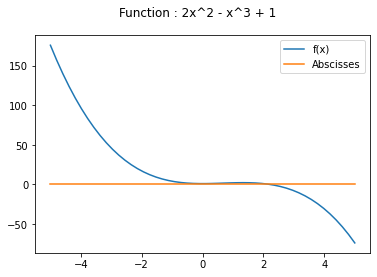

The approximation is = [[0, 10], [0.1, 6.926923076923076], [0.2, 4.901744585381556], [0.30000000000000004, 3.5921419992843013], [0.4, 2.7892387115023407], [0.5, 2.3673123903374425], [0.6, 2.2231691693981057], [0.7, 2.2058122254864885], [0.7999999999999999, 2.2055694775431514], [0.8999999999999999, 2.205569430400592], [0.9999999999999999, 2.2055694304005904], [1.0999999999999999, 2.2055694304005904], [1.2, 2.2055694304005904], [1.3, 2.2055694304005904], [1.4000000000000001, 2.2055694304005904], [1.5000000000000002, 2.2055694304005904], [1.6000000000000003, 2.2055694304005904], [1.7000000000000004, 2.2055694304005904], [1.8000000000000005, 2.2055694304005904], [1.9000000000000006, 2.2055694304005904], [2.0000000000000004, 2.2055694304005904], [2.1000000000000005, 2.2055694304005904], [2.2000000000000006, 2.2055694304005904], [2.3000000000000007, 2.2055694304005904], [2.400000000000001, 2.2055694304005904], [2.500000000000001, 2.2055694304005904], [2.600000000000001, 2.2055694304005904], 

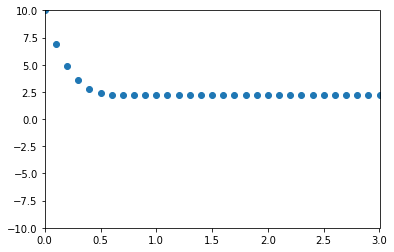

In [20]:
fig, ax = plt.subplots()
x_ = np.linspace(-5, 5)
y = 2*x_**2 - x_**3 + 1
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
fig.suptitle('Function : 2x^2 - x^3 + 1')
plt.show()

vec = 2*x**2 - x**3 + 1
res = FirstModel(vec, 10)
print(res)
absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])

plt.ylim([-10, 10])
plt.xlim([0, 3])
plt.scatter(absi, coords)



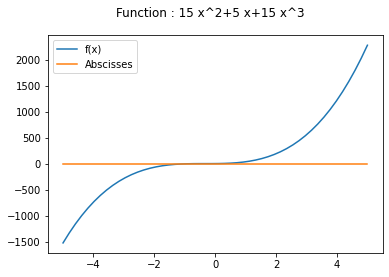

The approximation is = [[0, 1], [0.1, 0.5625], [0.2, 0.2792725797728502], [0.30000000000000004, 0.1079673297857783], [0.4, 0.024260767984329315], [0.5, 0.0016087349489681373], [0.6, 7.714422661595638e-06], [0.7, 1.7853144192563346e-10], [0.7999999999999999, 9.562042444990489e-20], [0.8999999999999999, 0.0], [0.9999999999999999, 0.0], [1.0999999999999999, 0.0], [1.2, 0.0], [1.3, 0.0], [1.4000000000000001, 0.0], [1.5000000000000002, 0.0], [1.6000000000000003, 0.0], [1.7000000000000004, 0.0], [1.8000000000000005, 0.0], [1.9000000000000006, 0.0], [2.0000000000000004, 0.0], [2.1000000000000005, 0.0], [2.2000000000000006, 0.0], [2.3000000000000007, 0.0], [2.400000000000001, 0.0], [2.500000000000001, 0.0], [2.600000000000001, 0.0], [2.700000000000001, 0.0], [2.800000000000001, 0.0], [2.9000000000000012, 0.0], [3.0000000000000013, 0.0]]


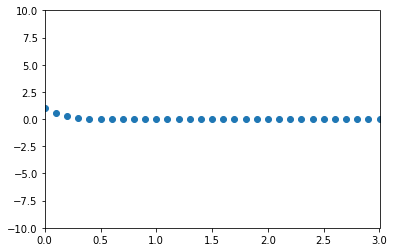

In [23]:
fig, ax = plt.subplots()
x_ = np.linspace(-5, 5)
y = 15*x_**(2) + 5*x_+ 15*x_**(3)
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
fig.suptitle('Function : 15 x^2+5 x+15 x^3')
plt.show()

vec = 15*x**(2) + 5*x + 15*x**(3)
res = FirstModel(vec, 1)
print(res)

absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])

plt.ylim([-10, 10])
plt.xlim([0, 3])
plt.scatter(absi, coords)


In [ ]:
fig, ax = plt.subplots()
x_ = np.linspace(-5, 5)
y = np.cos(x_) - x_**3
zero = 0*x_
ax.plot(x_, y, label ='f(x)')
ax.plot(x_, zero, label = 'Abscisses')
plt.legend()  
fig.suptitle('Wikipedia example : cos(x) - x^3 = 0')
plt.show()

vec = sp.cos(x) - x**3
res = FirstModel(vec, 1, 3)
print(res)